This is the first of the trials of implementing data frames and storing data to run more plots in efficient time

In [197]:
import os
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import scipy as sci
from scipy import integrate
from scipy.integrate import odeint
from astropy import units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import astropy.constants as const
import math

In [198]:
plt.rcParams['font.family'] = 'Times New Roman'
#this is to make the font of the plots to be Times New Roman

Initial conditions

Functions 

In [199]:
def semimajor_axis(r1_, r2_):
    '''
    This function calculated the semi-major axis. In this case, r=a
    '''
    return (np.linalg.norm(r2_ - r1_) / 2)
def sigma(m_gal_):
    '''
    This function calculates the velocity dispersion of the galaxy
    '''
    return (10**(2.2969)*(m_gal_/ (10**(11) * const.M_sun))**(0.299)) * (u.km/u.s)
def coulomb_log(a_, o_, G_, m_):

    '''
    Got this from implement df, making sure that both m1, and m2 can be used here
    '''
    x = (a_ * o_**(2)) / (G_ * m_)
    return math.log10(x.to_value(u.dimensionless_unscaled))
def DF_force(ln_A_, m_, r_choice_, rcom_, vfirst_, vsecond_, G_):
    '''
    Now we will only be looking at the force and then apply the acceleration later.
    Also added first and second to make sure that the negative signs are applied correctly
    '''

    F_D = 0.428 * ln_A_ * ((G_ * m_**(2))/(np.linalg.norm(r_choice_ - rcom_))**(2))

    v_r = vfirst_ - vsecond_

    v_rmag = np.linalg.norm(v_r) 

    v_rel_unit = (v_r / v_rmag)

    F_D_i = (F_D * v_rel_unit[0])
    F_D_j = (F_D * v_rel_unit[1])
    F_D_k = (F_D * v_rel_unit[2])
    
    # np.array([F_D_i.value, F_D_j.value, F_D_k.value])

    return np.array([F_D_i.to((u.kg*u.m)/(u.s**2)).value, F_D_j.to((u.kg*u.m)/ (u.s**2)).value, F_D_k.to((u.kg*u.m)/ (u.s**2)).value])
def twobodyeqn(w, t, G_, m1_, m2_, m_gal_, rcom_, r_, b_=1):
    '''
    I will try to make sure that this can be ran by odeint. To test efficiency. Also,
    I would like to see if calling functions within other functions would make it run
    '''
    r1 = w[:3] * u.pc
    r2 = w[3:6] * u.pc
    v1 = w[6:9] * u.km / u.s
    v2 = w[9:12] * u.km / u.s
    df_accel1 = w[12:15] * u.km / u.s**2
    df_accel2 = w[15:18] * u.km / u.s**2

    r = np.linalg.norm(r2 - r1)  # Distance between the two black holes

    a = semimajor_axis(r1, r2)
    o = sigma(m_gal_)
    ln_A1 = coulomb_log(a, o, G_, m_gal_)
    ln_A2 = coulomb_log(a, o, G_, m_gal_)


    df_force1 = DF_force(ln_A1, m1_, r1, rcom_, v2, v1, G_) * (u.kg * u.m / u.s**2)
    df_force2 = DF_force(ln_A2, m2_, r2, rcom_, v1, v2, G_) * (u.kg * u.m / u.s**2)


    df_accel1 = (df_force1 / m1_).to(u.km / u.s**2)
    df_accel2 = (df_force2 / m2_).to(u.km / u.s**2)


    dv1bydt = (G_ * m2_ * (r2 - r1) / r**3).to(u.km / u.s**2) 
    dv2bydt = (G_ * m1_ * (r1 - r2) / r**3).to(u.km / u.s**2) 


    dr1bydt = v1.to(u.km / u.s)
    dr2bydt = v2.to(u.km / u.s)

    derivs = np.concatenate([
        dr1bydt.to(u.km / u.s).value, dr2bydt.to(u.km / u.s).value,
        dv1bydt.to(u.km / u.s**2).value, dv2bydt.to(u.km / u.s**2).value,
        df_accel1.to(u.km / u.s**2).value, df_accel2.to(u.km / u.s**2).value
    ])

    return derivs

Kris' Equations from J1010 for DF checks

In [200]:
def find_reff(Mgal_):
    '''
    Find effective radius for galaxy given mstar.
    Uses Eq. 4 of Dabringhausen, Hilker \& Kroupa (2008)
    note: although this paper talks mostly about dwarfs,
    they do find that this particular equation fits
    massive ellipticals with M\gtrsim 10^11 Msun well.
    '''
    a = 2.95 
    b = 0.596
    return (a*(Mgal_/(1.e6*u.Msun))**b)*u.pc
def find_dyn_hard_radius(m_, mgal_, reff_):
    '''
    finds when stellar hardening takes over from
    dynamical friction
    uses Begelman+ (1980) Eq. in paragraph above Eq. 2
    should use rcore and mstar in core instead of reff
    and total mstar....that's why we don't actually use this.
    '''
    rb = (m_/mgal_)**(1./3.)*reff_
    # print("Binary radius is:", rb)
    return ((rb/reff_)**3*reff_).to(u.pc) #two equations in kris' source?
def BT_dyn_hard_radius(m1_,m2_, veldisp_):
    '''
    finds semi-major axis
    when stellar hardening takes over from
    dynamical friction
    BT Eq. 8.19
    '''
    massterm = (m1_+m2_)/(10**8*u.Msun)
    velterm = ((200*u.km/u.s)/veldisp_)**2
    return (10*u.pc*massterm*velterm).to(u.pc)
def dyn_timescale(m_, o_, a_, ln_A_):
    """"
    Finds the dynamical timescale.
    Computed according to equation 8.12 in B&T
    m_ is the secondary BH
    sigma_ is the vel disp of the stars in the core
    a_ is the initial semimajor axis
    """
    prefactor = 19./ln_A_
    aterm = (a_/(5.*u.kpc))**2
    vterm = o_/(200*u.km/u.s)
    mterm = (10**8*u.Msun/m_)
    return (prefactor*aterm*vterm*mterm*u.Gyr).to(u.Myr)


In [201]:
# region Code 1: IC's

G = const.G
m_gal = 2e11 * const.M_sun
#Masses
m1=4e8 * const.M_sun #mass of black hole A 
m2=4e8 * const.M_sun #mass of black hole B

#r_i has a separation of 430 pc
sep = 430*u.pc
r1_initial=[((sep/2.).value),0,0] * u.pc
r2_initial=[-((sep/2.).value),0,0] * u.pc
#To arrays
r1=np.array(r1_initial,dtype="float64") * u.pc
r2=np.array(r2_initial,dtype="float64") * u.pc
#COM
r_com=(m1*r1+m2*r2)/(m1+m2) 

# orb_v = (np.sqrt(const.G*(m1+m2)/a)).to(u.km/u.s) #added with Kris' source
#V_i
v1_initial=[0,100, 0] *u.km/u.s
v2_inital=[0,-100,0] *u.km/u.s #km/s

#To arrays
v1=np.array(v1_initial,dtype="float64") *u.km/u.s
v2=np.array(v2_inital,dtype="float64") *u.km/u.s
#Find velocity of COM
v_com=(m1*v1+m2*v2)/(m1+m2)

r = np.linalg.norm(r1 - r2) #separation between the two black holes (the magnitude of that)
# endregion
print(f'Initial conditions:\n • Position: {r1} {r2}\n • Velocity: {v1} {v2}')

Initial conditions:
 • Position: [215.   0.   0.] pc [-215.    0.    0.] pc
 • Velocity: [  0. 100.   0.] km / s [   0. -100.    0.] km / s


In [202]:
a = semimajor_axis(r1, r2)
o = sigma(m_gal)
ln_A1 = coulomb_log(a, o, G, m1)
ln_A2 = coulomb_log(a, o, G, m2)
r_eff = find_reff(m_gal)
r_dyn_hard = find_dyn_hard_radius(m1, m_gal, r_eff)
r_dyn_hard2 = find_dyn_hard_radius(m2, m_gal, r_eff)
final_radius = BT_dyn_hard_radius(m1, m2, o)
dyn_time = dyn_timescale(m1, o, a, ln_A1)
print(f'This system has a effective radius of {r_eff.to(u.pc)} and an initial separation of\n{a}')
print(f'and a dynamical hardening radius of {r_dyn_hard} or {r_dyn_hard2} (looking at both masses and see for diff)')
print(f'(final radius is {final_radius}), and it will be done with a total time of {dyn_time}')

This system has a effective radius of 4258.296459238662 pc and an initial separation of
215.0 pc
and a dynamical hardening radius of 8.516592918477325 pc or 8.516592918477325 pc (looking at both masses and see for diff)
(final radius is 53.86839560865153 pc), and it will be done with a total time of 12.293433921819046 Myr


Init df_accel?

In [203]:
df_force1 = DF_force(ln_A1, m1, r1, r_com, v2, v1, G) * u.kg * u.m / (u.s**2)
df_force2 = DF_force(ln_A2, m2, r2, r_com, v1, v2, G) * u.kg * u.m / (u.s**2)

print(df_force1)
df_accel1 = (df_force1 / m1).to(u.km/u.s**2)
df_accel2 = (df_force2 / m2).to(u.km/u.s**2)
print(f'The initial force on black hole 1 is {df_force1} and the acceleration is {df_accel1}')

[ 0.00000000e+00 -3.57469151e+29  0.00000000e+00] kg m / s2
The initial force on black hole 1 is [ 0.00000000e+00 -3.57469151e+29  0.00000000e+00] kg m / s2 and the acceleration is [ 0.00000000e+00 -4.49440978e-13  0.00000000e+00] km / s2


Now, we will run with odeint

In [204]:
T = dyn_time
N = 10000
delta_t = T/N
print(delta_t)
init_params = np.array([r1, r2, v1, v2, df_accel1, df_accel2])
init_params = init_params.flatten()
time_span = np.linspace(0, T, N)
# region code 2: ODE
two_body_sol = sci.integrate.odeint(twobodyeqn, init_params, time_span, args=(G, m1, m2, m_gal, r_com, r))
r1_sol = two_body_sol[:, :3]
r2_sol = two_body_sol[:, 3:6]
v1_sol = two_body_sol[:, 6:9]
v2_sol = two_body_sol[:, 9:12]
df_accel1_sol = two_body_sol[:, 12:15]
df_accel2_sol = two_body_sol[:, 15:18]
r_com_sol = (m1 * r1_sol + m2 * r2_sol) / (m1 + m2)
r1com_sol = r1_sol - r_com_sol
r2com_sol = r2_sol - r_com_sol
# endregion

print(df_accel1_sol)

0.0012293433921819047 Myr
[[ 0.00000000e+00 -4.49440978e-13  0.00000000e+00]
 [-2.15094968e-33 -4.48280571e-13  0.00000000e+00]
 [-8.60379231e-33 -4.47120166e-13  0.00000000e+00]
 ...
 [-4.03015907e-27  1.03898982e-12  0.00000000e+00]
 [-4.03018863e-27  1.03899765e-12  0.00000000e+00]
 [-4.03021819e-27  1.03900548e-12  0.00000000e+00]]


Now plotting this:

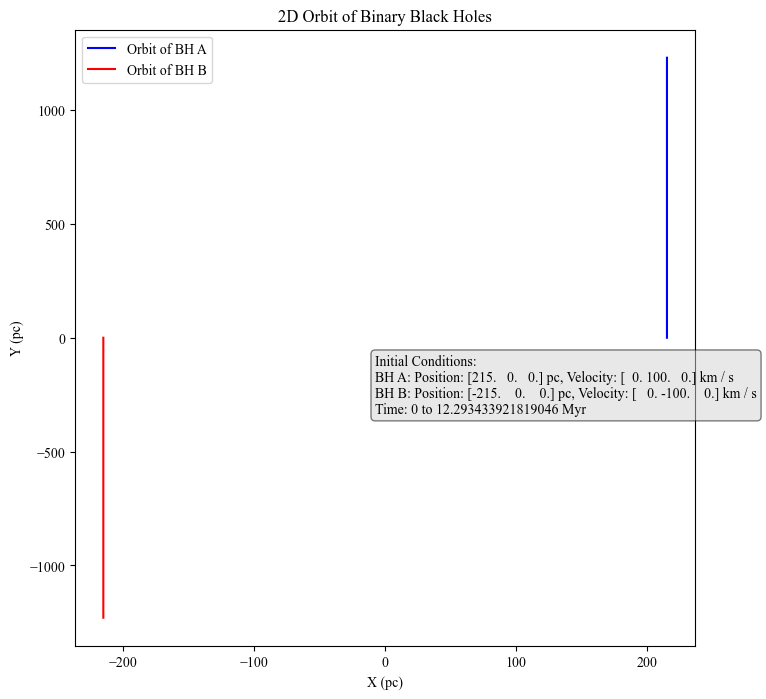

In [205]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)  # No projection='3d' for 2D plot

ax.plot(r1_sol[:, 0], r1_sol[:, 1], label="Orbit of BH A", color="blue")
ax.plot(r2_sol[:, 0], r2_sol[:, 1], label="Orbit of BH B", color="red")


ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)')
ax.set_title('2D Orbit of Binary Black Holes')


ax.legend()


initial_conditions_text = (
    f"Initial Conditions:\n"
    f"BH A: Position: {r1_initial}, Velocity: {v1_initial}\n"
    f"BH B: Position: {r2_initial}, Velocity: {v2_inital}\n"
    f"Time: 0 to {T}"
)
fig.text(0.5, 0.4, initial_conditions_text, fontsize=10, bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.5))

# Show the plot
plt.show()